# Train MLP with PyTorch

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import deque

import csv

In [18]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class PendulumDataset(Dataset):
    def __init__(self, csv_file):
        # Read the CSV file (no header row)
        df = pd.read_csv(csv_file, header=None)

        # Convert each column to a numeric type, coerce errors to NaN
        df = df.apply(pd.to_numeric, errors='coerce')
        # Drop any rows that contain NaN (from invalid conversions)
        df = df.dropna()

        # Rename columns for convenience
        df.columns = ["theta", "theta_dot", "control", "theta_next", "theta_dot_next"]
        
        # Now extract input features and targets
        self.X = df[["theta", "theta_dot", "control"]].values
        self.y = df[["theta_next", "theta_dot_next"]].values
        
        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------------------
# 2. Define the MLP Model in PyTorch
# -------------------------------
class PendulumMLP(nn.Module):
    """
    A simple feedforward neural network (MLP) to predict
    (theta_next, theta_dot_next) from (theta, theta_dot, control).
    """
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=2):
        super(PendulumMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


# ---------------
# 3. Train Model
# ---------------
def train_model(
    model,
    train_loader,
    num_epochs=50,
    lr=1e-3,
    device="cpu"
):
    # Use Mean Squared Error loss
    criterion = nn.MSELoss()
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Move model to device (CPU or GPU)
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
        
        # Compute average loss over this epoch
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    
    print("Training complete.")


 # Hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 1e-3

# Initialize dataset and dataloader
dataset = PendulumDataset("./data/pendulum_dataset.csv")
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate model
model = PendulumMLP(input_dim=3, hidden_dim=64, output_dim=2)

# Train the model
train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="gpu")

# Example: After training, let's do a quick inference on the first sample
model.eval()
X_sample, y_sample = dataset[0]
with torch.no_grad():
    y_pred = model(X_sample.unsqueeze(0))  # unsqueeze for batch dimension
print(f"Input (theta, theta_dot, control)    = {X_sample}")
print(f"True (theta_next, theta_dot_next)   = {y_sample}")
print(f"Predicted (theta_next, theta_dot_next) = {y_pred.squeeze(0)}")

X_sample, y_sample = dataset[10]
with torch.no_grad():
    y_pred = model(X_sample.unsqueeze(0))  # unsqueeze for batch dimension
print(f"Input (theta, theta_dot, control)    = {X_sample}")
print(f"True (theta_next, theta_dot_next)   = {y_sample}")
print(f"Predicted (theta_next, theta_dot_next) = {y_pred.squeeze(0)}")


Epoch [1/50], Loss: 10.993476
Epoch [2/50], Loss: 0.084586
Epoch [3/50], Loss: 0.010904
Epoch [4/50], Loss: 0.003877
Epoch [5/50], Loss: 0.002109
Epoch [6/50], Loss: 0.001422
Epoch [7/50], Loss: 0.001067
Epoch [8/50], Loss: 0.000779
Epoch [9/50], Loss: 0.000627
Epoch [10/50], Loss: 0.000505
Epoch [11/50], Loss: 0.000426
Epoch [12/50], Loss: 0.000346
Epoch [13/50], Loss: 0.000315
Epoch [14/50], Loss: 0.000326
Epoch [15/50], Loss: 0.000237
Epoch [16/50], Loss: 0.000249
Epoch [17/50], Loss: 0.000487
Epoch [18/50], Loss: 0.000350
Epoch [19/50], Loss: 0.002740
Epoch [20/50], Loss: 0.000256
Epoch [21/50], Loss: 0.000299
Epoch [22/50], Loss: 0.000258
Epoch [23/50], Loss: 0.000713
Epoch [24/50], Loss: 0.000166
Epoch [25/50], Loss: 0.001427
Epoch [26/50], Loss: 0.000169
Epoch [27/50], Loss: 0.003297
Epoch [28/50], Loss: 0.000398
Epoch [29/50], Loss: 0.000156
Epoch [30/50], Loss: 0.000231
Epoch [31/50], Loss: 0.000490
Epoch [32/50], Loss: 0.001662
Epoch [33/50], Loss: 0.000223
Epoch [34/50], Los

MSE Theta:      9.434670
MSE Theta_Dot:  11.387842


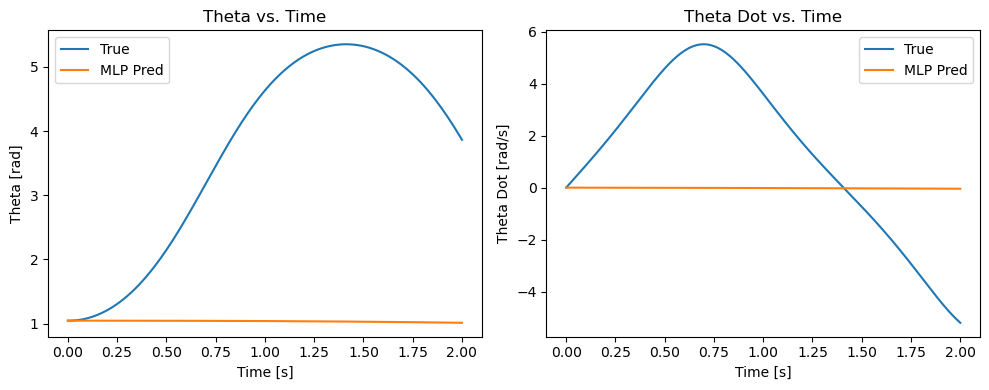

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def simulate_ground_truth(theta0, theta_dot0, control=0.0, dt=0.01, steps=100):
    """
    Simulate the pendulum with known/analytical dynamics or from
    your own ground-truth data. Replace this function with your actual
    simulator or real data lookup if necessary.
    
    Returns:
      theta_traj, theta_dot_traj (both numpy arrays of length `steps+1`)
    """
    # For a simple pendulum: theta_ddot = -(g / L) * sin(theta) + control
    # Just an example. Not guaranteed to match your data exactly!
    g = 9.81
    L = 1.0
    
    theta_traj = np.zeros(steps + 1)
    theta_dot_traj = np.zeros(steps + 1)
    theta_traj[0] = theta0
    theta_dot_traj[0] = theta_dot0
    
    for t in range(steps):
        theta = theta_traj[t]
        theta_dot = theta_dot_traj[t]
        
        # Example dynamics, ignoring damping or friction:
        theta_ddot = (g/L) * np.sin(theta) + control

        # Euler integration:
        theta_dot_new = theta_dot + theta_ddot * dt
        theta_new = theta + theta_dot * dt
        
        theta_traj[t+1] = theta_new
        theta_dot_traj[t+1] = theta_dot_new

    return theta_traj, theta_dot_traj


def simulate_mlp(model, theta0, theta_dot0, control=0.0, dt=0.01, steps=100, device='cpu'):
    """
    Use the trained MLP (which outputs ddtheta) to roll out predictions
    for multiple steps via Euler integration.
    
    Returns:
      theta_pred, theta_dot_pred (numpy arrays of length `steps+1`)
    """
    model.eval()  # set model to evaluation mode
    
    theta_pred = np.zeros(steps + 1)
    theta_dot_pred = np.zeros(steps + 1)
    
    theta_pred[0] = theta0
    theta_dot_pred[0] = theta_dot0
    
    with torch.no_grad():
        for t in range(steps):
            th_t = theta_pred[t]
            thd_t = theta_dot_pred[t]

            # Prepare input to MLP
            # shape (1,3) => [theta, theta_dot, control]
            curr_input = torch.tensor([th_t, thd_t, control], dtype=torch.float32)
            curr_input = curr_input.unsqueeze(0).to(device)

            # MLP outputs ddtheta (shape (1,2))
            ddtheta = model(curr_input)
            ddtheta = ddtheta.squeeze(0).cpu().numpy()
            ddtheta = ddtheta[0]  # take the first element as ddtheta
            
            # Euler integration for next step
            theta_dot_pred[t+1] = thd_t + ddtheta * dt
            theta_pred[t+1] = th_t + thd_t * dt
    return theta_pred, theta_dot_pred


def compare_trajectories(model, theta0, theta_dot0, control=0.0, steps=100, dt=0.01):
    """
    Compare the MLP-based trajectory vs. ground truth
    and optionally plot the results.
    """
    # 1) Generate or load the ground truth trajectory
    theta_true, theta_dot_true = simulate_ground_truth(theta0, theta_dot0, control=control, dt=dt, steps=steps)
    
    # 2) Roll out MLP predictions
    theta_mlp, theta_dot_mlp = simulate_mlp(model, theta0, theta_dot0, control=control, dt=dt, steps=steps)
    
    # 3) Compute error metrics (e.g., MSE)
    mse_theta = np.mean((theta_true - theta_mlp)**2)
    mse_theta_dot = np.mean((theta_dot_true - theta_dot_mlp)**2)
    print(f"MSE Theta:      {mse_theta:.6f}")
    print(f"MSE Theta_Dot:  {mse_theta_dot:.6f}")
    
    # 4) Plot the two trajectories for visual inspection
    t_vals = np.linspace(0, steps*dt, steps+1)
    plt.figure(figsize=(10, 4))
    
    # Plot theta
    plt.subplot(1, 2, 1)
    plt.plot(t_vals, theta_true, label='True')
    plt.plot(t_vals, theta_mlp, label='MLP Pred')
    plt.title("Theta vs. Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Theta [rad]")
    plt.legend()
    
    # Plot theta_dot
    plt.subplot(1, 2, 2)
    plt.plot(t_vals, theta_dot_true, label='True')
    plt.plot(t_vals, theta_dot_mlp, label='MLP Pred')
    plt.title("Theta Dot vs. Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Theta Dot [rad/s]")
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# 2) Choose initial condition
theta0 = np.pi/3
theta_dot0 = 0.0

# 3) Compare MLP rollout with (some) ground truth simulator
compare_trajectories(model, theta0, theta_dot0, control=0.0, steps=200, dt=0.01)
